# Übungsaufgaben 3




## Aufgabe 1 (eigenen Sentence-Segmenter erstellen)

Satzsegmentierung (End-of-Sentence-Detection) kann als binäre Klassifikation verstanden werden (s. https://www.nltk.org/book/ch06.html#sentence-segmentation), die für jedes Token in einem Korpus entscheidet, ob es ein ***sentence boundary token*** ist oder nicht. Dies ist genauer eine **Sequenzklassifikation**, da die Entscheidung abhängt vom ***Kontext der Punktuationszeichen*** (z.B. `['Mr', '.']`).


Erzeugen Sie einen ***(1) regelbasierten*** sowie einen ***(2) auf Satz-Segmentationsdaten der Penn-Treebank trainierten*** **Punktuationsklassifikator zur Satzsegmentierung**. 

Input soll eine Wordliste mit einer einfachen Tokenisierung sein, wie in folgendem englischen Beispielsatz, mit dem Sie Ihre Klassifikatoren auch testen sollen.




In [1]:
text = "You hear that Mr. Anderson? That is the sound of inevitability. Good-bye, Mr. Anderson! END"

In [2]:
import re
test_words = re.findall(r'\w+|[^\w\s]+', text)  #entspricht nltk.wordpunct_tokenize
print(test_words)

['You', 'hear', 'that', 'Mr', '.', 'Anderson', '?', 'That', 'is', 'the', 'sound', 'of', 'inevitability', '.', 'Good', '-', 'bye', ',', 'Mr', '.', 'Anderson', '!', 'END']


##### Erklärung zum wordpunct_tokenize-REGEXP:

In [3]:
print(re.findall(r'\w+', text)) #findet alle Wörter

['You', 'hear', 'that', 'Mr', 'Anderson', 'That', 'is', 'the', 'sound', 'of', 'inevitability', 'Good', 'bye', 'Mr', 'Anderson', 'END']


In [4]:
print(re.findall(r'[^\w\s]+', text)) #findet alle Punktuationszeichen

['.', '?', '.', '-', ',', '.', '!']


In [5]:
print(re.findall(r'[^\s]+', text)) #\s matches whitespace characters

['You', 'hear', 'that', 'Mr.', 'Anderson?', 'That', 'is', 'the', 'sound', 'of', 'inevitability.', 'Good-bye,', 'Mr.', 'Anderson!', 'END']


### Aufgabe 1a (Rule-based Sentence Segmentation)


Erstellen Sie einen einfachen regelbasierten Punctuation Tagger, der eine Liste von Wort- und Punktuationstokens in eine Liste von entsprechenden Satz-Tokenlisten auftrennt. Orientieren Sie sich dabei an https://en.wikipedia.org/wiki/Sentence_boundary_disambiguation:

>   (a) If it's a period, it ends a sentence.<br>
    (b) If the preceding token is in the hand-compiled list of abbreviations, then it doesn't end a sentence.<br>
    (c) If the next token is capitalized, then it ends a sentence.        


In [6]:
def segment_sentences_rule_based(words):
    sent_list = []
    sent = []
    for index,token in enumerate(words):
        sent.append(token)
        if token in '.?!' and words[index-1] not in ["Mr", "Mrs", "Ms", "Dr"] and words[index+1][0].isupper():
            sent_list.append(sent)
            sent = []
    return sent_list  

In [7]:
segment_sentences_rule_based(test_words)

[['You', 'hear', 'that', 'Mr', '.', 'Anderson', '?'],
 ['That', 'is', 'the', 'sound', 'of', 'inevitability', '.'],
 ['Good', '-', 'bye', ',', 'Mr', '.', 'Anderson', '!']]

### Aufgabe 1b (Supervised Sentence Segmentation)

Trainieren Sie einen Punctuation Classifier mit Hilfe der Daten zur Satzsegmentierung der Penn-Treebank. Orientieren Sie sich dabei am Vorgehen in https://www.nltk.org/book/ch06.html#sentence-segmentation:

- extract features for possible sentence-boundary tokens
- learn mapping from feature-representations to binary end-of-sentence classes (boundary yes/no) 
- training data: corpus with annotation of sentence boundaries (e.g. treebanks)


In [8]:
import nltk
from nltk.corpus import treebank # Sample of Penn Treebank

##### Use Penn Treebank as Training Data:

In [9]:
#The first step is to obtain some data that has already been segmented into sentences 
#and convert it into a form that is suitable for extracting features:
sents = nltk.corpus.treebank_raw.sents()

In [10]:
print(sents[0:3])

[['.', 'START'], ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov', '.', '29', '.'], ['Mr', '.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N', '.', 'V', '.,', 'the', 'Dutch', 'publishing', 'group', '.']]


In [11]:
#Here, tokens is a merged list of tokens from the individual sentences, 
#and boundaries is a set containing the indexes of all sentence-boundary tokens. 
tokens = []
boundaries = set()
offset = 0
for sent in sents:
    tokens.extend(sent)
    offset += len(sent)
    boundaries.add(offset-1)

In [12]:
[(index, token) for index,token in enumerate(tokens[0:40])]

[(0, '.'),
 (1, 'START'),
 (2, 'Pierre'),
 (3, 'Vinken'),
 (4, ','),
 (5, '61'),
 (6, 'years'),
 (7, 'old'),
 (8, ','),
 (9, 'will'),
 (10, 'join'),
 (11, 'the'),
 (12, 'board'),
 (13, 'as'),
 (14, 'a'),
 (15, 'nonexecutive'),
 (16, 'director'),
 (17, 'Nov'),
 (18, '.'),
 (19, '29'),
 (20, '.'),
 (21, 'Mr'),
 (22, '.'),
 (23, 'Vinken'),
 (24, 'is'),
 (25, 'chairman'),
 (26, 'of'),
 (27, 'Elsevier'),
 (28, 'N'),
 (29, '.'),
 (30, 'V'),
 (31, '.,'),
 (32, 'the'),
 (33, 'Dutch'),
 (34, 'publishing'),
 (35, 'group'),
 (36, '.'),
 (37, '.'),
 (38, 'START'),
 (39, 'Rudolph')]

In [13]:
sorted(list(boundaries))[0:4]

[1, 20, 36, 38]

---
##### Feature-Extraction:

In [14]:
#Next, we need to specify the features of the data that will be used 
#in order to decide whether punctuation indicates a sentence-boundary:
def punct_features(tokens, i):
    return {'next-word-capitalized': tokens[i+1][0].isupper(),
            'prev-word': tokens[i-1].lower(),
            'punct': tokens[i],
            'prev-word-is-one-char': len(tokens[i-1]) == 1}

In [15]:
#Based on this feature extractor, we can create a list of labeled featuresets 
#by selecting all the punctuation tokens, and tagging whether they are boundary tokens or not:
featuresets = [(punct_features(tokens, i), (i in boundaries))
    for i in range(1, len(tokens)-1)
    if tokens[i] in '.?!']

In [16]:
featuresets[0:5]

[({'next-word-capitalized': False,
   'prev-word': 'nov',
   'prev-word-is-one-char': False,
   'punct': '.'},
  False),
 ({'next-word-capitalized': True,
   'prev-word': '29',
   'prev-word-is-one-char': False,
   'punct': '.'},
  True),
 ({'next-word-capitalized': True,
   'prev-word': 'mr',
   'prev-word-is-one-char': False,
   'punct': '.'},
  False),
 ({'next-word-capitalized': True,
   'prev-word': 'n',
   'prev-word-is-one-char': True,
   'punct': '.'},
  False),
 ({'next-word-capitalized': False,
   'prev-word': 'group',
   'prev-word-is-one-char': False,
   'punct': '.'},
  True)]

---
##### Train Simple Probabilistic Classifier (Naive Bayes):

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [17]:
#Using these featuresets, we can train and evaluate a punctuation classifier:
size = int(len(featuresets) * 0.1)
train_set, test_set = featuresets[size:], featuresets[:size]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.936026936026936

In [18]:
# Natural Language Toolkit: code_classification_based_segmenter

def segment_sentences(words):
    start = 0
    sents = []
    for i, word in enumerate(words):
        if word in '.?!' and classifier.classify(punct_features(words, i)) == True:
            sents.append(words[start:i+1])
            start = i+1
    if start < len(words):
        sents.append(words[start:])
    return sents

In [19]:
print(test_words)

['You', 'hear', 'that', 'Mr', '.', 'Anderson', '?', 'That', 'is', 'the', 'sound', 'of', 'inevitability', '.', 'Good', '-', 'bye', ',', 'Mr', '.', 'Anderson', '!', 'END']


In [20]:
segment_sentences(test_words)

[['You', 'hear', 'that', 'Mr', '.', 'Anderson', '?'],
 ['That', 'is', 'the', 'sound', 'of', 'inevitability', '.'],
 ['Good', '-', 'bye', ',', 'Mr', '.', 'Anderson', '!'],
 ['END']]

## Aufgabe 2 (Korpusannotation mit stanza)

Annotieren Sie den Text in `wahlverwandschaften.txt` nach morphologischen, syntaktischen und semantischen Kategorien mit Hilfe der deutschen stanza-Modelle.

Verwenden Sie dabei auch die CoNLL-Utilities von stanza für eine Transformation eines Dependency-analysierten Satzes in das CoNLL-Format, um es als NLTK-Dependency-Tree-Objekt einzulesen und zu plotten.

In [21]:
import stanza
#stanza.download('de')

### 2a: morphologische Analyse:

In [22]:
text = open('wahlverwandschaften.txt').read()
nlp = stanza.Pipeline(lang='de', processors='tokenize, mwt, lemma, pos')
doc = nlp(text)#[0:1000])

2022-06-02 14:05:27 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2022-06-02 14:05:27 INFO: Use device: cpu
2022-06-02 14:05:27 INFO: Loading: tokenize
2022-06-02 14:05:27 INFO: Loading: mwt
2022-06-02 14:05:27 INFO: Loading: pos
2022-06-02 14:05:28 INFO: Loading: lemma
2022-06-02 14:05:28 INFO: Done loading processors!


In [23]:
doc.sentences[0:1]

[[
   {
     "id": 1,
     "text": "Die",
     "lemma": "der",
     "upos": "DET",
     "xpos": "ART",
     "feats": "Case=Nom|Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
     "start_char": 0,
     "end_char": 3
   },
   {
     "id": 2,
     "text": "Wahlverwandtschaften",
     "lemma": "Wahlverwandtschaft",
     "upos": "NOUN",
     "xpos": "NN",
     "feats": "Case=Nom|Gender=Fem|Number=Plur",
     "start_char": 4,
     "end_char": 24
   }
 ]]

In [24]:
print(*[f'{word.text}' for sent in doc.sentences[6:7] for word in sent.words], sep=' ')

Sein Geschäft war eben vollendet ;


In [25]:
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc.sentences[6:7] for word in sent.words], sep='\n')

word: Sein 	lemma: sein	upos: DET	xpos: PPOSAT	feats: Case=Nom|Gender=Neut|Gender[psor]=Masc,Neut|Number=Sing|Number[psor]=Sing|Person=3|Poss=Yes|PronType=Prs
word: Geschäft 	lemma: Geschäft	upos: NOUN	xpos: NN	feats: Case=Nom|Gender=Neut|Number=Sing
word: war 	lemma: sein	upos: AUX	xpos: VAFIN	feats: Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin
word: eben 	lemma: eben	upos: ADV	xpos: ADV	feats: _
word: vollendet 	lemma: vollenden	upos: ADJ	xpos: VVPP	feats: VerbForm=Part
word: ; 	lemma: ;	upos: PUNCT	xpos: $.	feats: _


### 2b: Sentiment Analysis:

In [26]:
nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')
doc = nlp(text[0:1000])

for i, sentence in enumerate(doc.sentences):
    print('=> sentence',i, ': sentiment:', sentence.sentiment)
    print(*[f'{word.text}' for word in sentence.words], sep=' ')

2022-06-02 14:05:43 WARNING: Language de package default expects mwt, which has been added
2022-06-02 14:05:43 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| sentiment | sb10k   |

2022-06-02 14:05:43 INFO: Use device: cpu
2022-06-02 14:05:43 INFO: Loading: tokenize
2022-06-02 14:05:43 INFO: Loading: mwt
2022-06-02 14:05:43 INFO: Loading: sentiment
2022-06-02 14:05:44 INFO: Done loading processors!


=> sentence 0 : sentiment: 1
Die Wahlverwandtschaften
=> sentence 1 : sentiment: 1
Ein Roman
=> sentence 2 : sentiment: 1
von Johann Wolfgang von Goethe
=> sentence 3 : sentiment: 1
Erster Teil
=> sentence 4 : sentiment: 1
Erstes Kapitel
=> sentence 5 : sentiment: 1
Eduard—so nennen wir einen reichen Baron in dem besten Mannesalter — Eduard hatte in seiner Baumschule die schönste Stunde eines Aprilnachmittags zugebracht , um frisch erhaltene Pfropfreiser auf junge Stämme zu bringen .
=> sentence 6 : sentiment: 0
Sein Geschäft war eben vollendet ;
=> sentence 7 : sentiment: 1
er legte die Gerätschaften in das Futteral zusammen und betrachtete seine Arbeit mit Vergnügen , als der Gärtner hinzutrat und sich an dem teilnehmenden Fleiße des Herrn ergetzte .
=> sentence 8 : sentiment: 1
„ Hast du meine Frau nicht gesehen ? “ fragte Eduard , indem er sich weiterzugehen anschickte .
=> sentence 9 : sentiment: 1
„ Drüben in den neuen Anlagen “ , versetzte der Gärtner .
=> sentence 10 : sentimen

### 2c: NER:

In [27]:
nlp = stanza.Pipeline(lang='de', processors='tokenize,ner')
doc = nlp(text[0:2500])

# sentence based NER output
print(*[f'entity: {ent.text}\ttype: {ent.type}' for ent in doc.ents], sep='\n')

2022-06-02 14:05:45 WARNING: Language de package default expects mwt, which has been added
2022-06-02 14:05:45 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| ner       | conll03 |

2022-06-02 14:05:45 INFO: Use device: cpu
2022-06-02 14:05:45 INFO: Loading: tokenize
2022-06-02 14:05:45 INFO: Loading: mwt
2022-06-02 14:05:45 INFO: Loading: ner
2022-06-02 14:05:46 INFO: Done loading processors!


entity: Johann Wolfgang von Goethe	type: PER
entity: Eduard—so	type: PER
entity: Eduard	type: PER
entity: Eduard	type: PER
entity: Eduard	type: PER
entity: Eduard	type: PER
entity: Eduard	type: PER
entity: Mooshütte	type: LOC
entity: Charlotte	type: PER


### 2d: Dependencies:

##### Inklusive Transformation in CONLL-Format für Plotting mit NLTK

In [28]:
nlp = stanza.Pipeline(lang='de', processors='tokenize,pos,lemma,depparse')
doc = nlp(text[0:1000])

2022-06-02 14:05:48 WARNING: Language de package default expects mwt, which has been added
2022-06-02 14:05:48 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |

2022-06-02 14:05:48 INFO: Use device: cpu
2022-06-02 14:05:48 INFO: Loading: tokenize
2022-06-02 14:05:48 INFO: Loading: mwt
2022-06-02 14:05:48 INFO: Loading: pos
2022-06-02 14:05:48 INFO: Loading: lemma
2022-06-02 14:05:48 INFO: Loading: depparse
2022-06-02 14:05:49 INFO: Done loading processors!


In [29]:
doc.sentences[0:1]

[[
   {
     "id": 1,
     "text": "Die",
     "lemma": "der",
     "upos": "DET",
     "xpos": "ART",
     "feats": "Case=Nom|Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
     "head": 2,
     "deprel": "det",
     "start_char": 0,
     "end_char": 3
   },
   {
     "id": 2,
     "text": "Wahlverwandtschaften",
     "lemma": "Wahlverwandtschaft",
     "upos": "NOUN",
     "xpos": "NN",
     "feats": "Case=Nom|Gender=Fem|Number=Plur",
     "head": 0,
     "deprel": "root",
     "start_char": 4,
     "end_char": 24
   }
 ]]

In [30]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences[8:9] for word in sent.words], sep='\n')

id: 1	word: „	head id: 7	head: gesehen	deprel: punct
id: 2	word: Hast	head id: 7	head: gesehen	deprel: aux
id: 3	word: du	head id: 7	head: gesehen	deprel: nsubj
id: 4	word: meine	head id: 5	head: Frau	deprel: det:poss
id: 5	word: Frau	head id: 7	head: gesehen	deprel: obj
id: 6	word: nicht	head id: 7	head: gesehen	deprel: advmod
id: 7	word: gesehen	head id: 10	head: fragte	deprel: ccomp
id: 8	word: ?	head id: 7	head: gesehen	deprel: punct
id: 9	word: “	head id: 7	head: gesehen	deprel: punct
id: 10	word: fragte	head id: 0	head: root	deprel: root
id: 11	word: Eduard	head id: 10	head: fragte	deprel: nsubj
id: 12	word: ,	head id: 17	head: anschickte	deprel: punct
id: 13	word: indem	head id: 17	head: anschickte	deprel: mark
id: 14	word: er	head id: 17	head: anschickte	deprel: nsubj
id: 15	word: sich	head id: 17	head: anschickte	deprel: obj
id: 16	word: weiterzugehen	head id: 17	head: anschickte	deprel: xcomp
id: 17	word: anschickte	head id: 10	head: fragte	deprel: advcl
id: 18	word: .	head i

In [31]:
dicts = doc.to_dict() # dicts is List[List[Dict]], representing each token / word in each sentence in the document
#dicts[0]

from stanza.utils.conll import CoNLL
conll = CoNLL.convert_dict(dicts) # conll is List[List[List]], representing each token / word in each sentence in the document
print(conll[8])

[['1', '„', '"', 'PUNCT', '$(', '_', '7', 'punct', '_', 'start_char=533|end_char=534'], ['2', 'Hast', 'haben', 'AUX', 'VAFIN', 'Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin', '7', 'aux', '_', 'start_char=534|end_char=538'], ['3', 'du', 'du', 'PRON', 'PPER', 'Case=Nom|Number=Sing|Person=2|PronType=Prs', '7', 'nsubj', '_', 'start_char=539|end_char=541'], ['4', 'meine', 'mein', 'DET', 'PPOSAT', 'Case=Acc|Gender=Fem|Number=Sing|Number[psor]=Sing|Person=1|Poss=Yes|PronType=Prs', '5', 'det:poss', '_', 'start_char=542|end_char=547'], ['5', 'Frau', 'Frau', 'NOUN', 'NN', 'Case=Acc|Gender=Fem|Number=Sing', '7', 'obj', '_', 'start_char=548|end_char=552'], ['6', 'nicht', 'nicht', 'PART', 'PTKNEG', 'Polarity=Neg', '7', 'advmod', '_', 'start_char=553|end_char=558'], ['7', 'gesehen', 'sehen', 'VERB', 'VVPP', 'VerbForm=Part', '10', 'ccomp', '_', 'start_char=559|end_char=566'], ['8', '?', '?', 'PUNCT', '$.', '_', '7', 'punct', '_', 'start_char=566|end_char=567'], ['9', '“', '"', 'PUNCT', '$(',

In [32]:
tree_string = '\n'.join(['\t'.join(x) for x in conll[8]])
tree_string

'1\t„\t"\tPUNCT\t$(\t_\t7\tpunct\t_\tstart_char=533|end_char=534\n2\tHast\thaben\tAUX\tVAFIN\tMood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin\t7\taux\t_\tstart_char=534|end_char=538\n3\tdu\tdu\tPRON\tPPER\tCase=Nom|Number=Sing|Person=2|PronType=Prs\t7\tnsubj\t_\tstart_char=539|end_char=541\n4\tmeine\tmein\tDET\tPPOSAT\tCase=Acc|Gender=Fem|Number=Sing|Number[psor]=Sing|Person=1|Poss=Yes|PronType=Prs\t5\tdet:poss\t_\tstart_char=542|end_char=547\n5\tFrau\tFrau\tNOUN\tNN\tCase=Acc|Gender=Fem|Number=Sing\t7\tobj\t_\tstart_char=548|end_char=552\n6\tnicht\tnicht\tPART\tPTKNEG\tPolarity=Neg\t7\tadvmod\t_\tstart_char=553|end_char=558\n7\tgesehen\tsehen\tVERB\tVVPP\tVerbForm=Part\t10\tccomp\t_\tstart_char=559|end_char=566\n8\t?\t?\tPUNCT\t$.\t_\t7\tpunct\t_\tstart_char=566|end_char=567\n9\t“\t"\tPUNCT\t$(\t_\t7\tpunct\t_\tstart_char=567|end_char=568\n10\tfragte\tfragen\tVERB\tVVFIN\tMood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin\t0\troot\t_\tstart_char=569|end_char=575\n11\tEduard\t

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/parse/dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


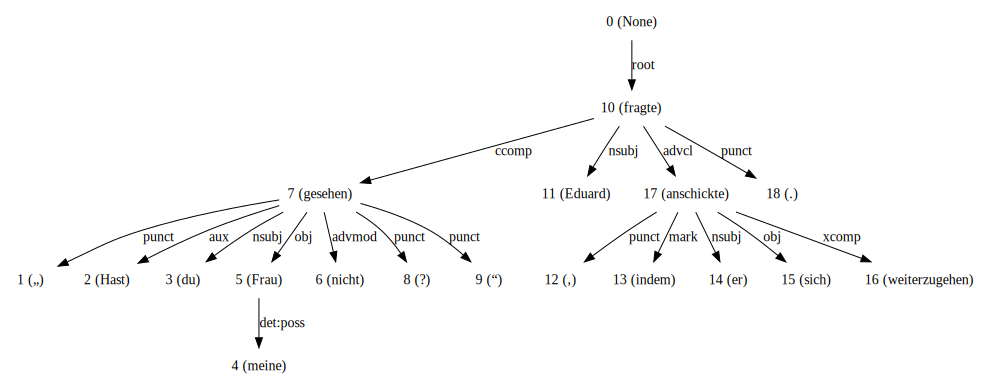

In [33]:
from nltk import DependencyGraph
t = DependencyGraph(tree_string)
t

## Aufgabe 3 (Weiterverarbeitung Korpusannotation)

Führen Sie auf dem Wahlverwandschaften-Text mit stanza ein POS-Tagging aus und verwenden Sie die Ausgabe für eine POS-Frequenzzählung und Plotting der Ergebnisse.

In [34]:
text = open('wahlverwandschaften.txt').read()
nlp = stanza.Pipeline(lang='de', processors='tokenize, mwt, pos')
doc = nlp(text)

2022-06-02 14:05:49 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |

2022-06-02 14:05:49 INFO: Use device: cpu
2022-06-02 14:05:49 INFO: Loading: tokenize
2022-06-02 14:05:49 INFO: Loading: mwt
2022-06-02 14:05:49 INFO: Loading: pos
2022-06-02 14:05:50 INFO: Done loading processors!


In [35]:
doc.sentences[0].words

[{
   "id": 1,
   "text": "Die",
   "upos": "DET",
   "xpos": "ART",
   "feats": "Case=Nom|Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
   "start_char": 0,
   "end_char": 3
 }, {
   "id": 2,
   "text": "Wahlverwandtschaften",
   "upos": "NOUN",
   "xpos": "NN",
   "feats": "Case=Nom|Gender=Fem|Number=Plur",
   "start_char": 4,
   "end_char": 24
 }]

In [36]:
tagged_text = [(word.text,word.upos) for sent in doc.sentences for word in sent.words]
tagged_text[0:5]

[('Die', 'DET'),
 ('Wahlverwandtschaften', 'NOUN'),
 ('Ein', 'DET'),
 ('Roman', 'NOUN'),
 ('von', 'ADP')]

In [37]:
from collections import Counter
pos_count = Counter(tag for _, tag in tagged_text)

In [38]:
pos_count.keys()

dict_keys(['DET', 'NOUN', 'ADP', 'PROPN', 'ADJ', 'VERB', 'PRON', 'PUNCT', 'AUX', 'PART', 'ADV', 'CCONJ', 'SCONJ', 'NUM'])

In [39]:
pos_count.values()

dict_values([1179, 1728, 919, 185, 878, 1476, 1854, 2331, 608, 277, 1297, 434, 313, 11])

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

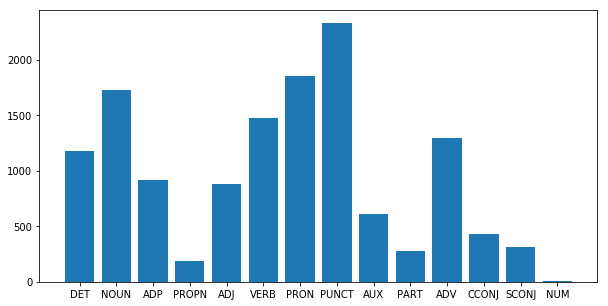

In [41]:
height = pos_count.values()
bars = pos_count.keys()

y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

In [42]:
sorted_pos_count = pos_count.most_common()
sorted_pos_count

[('PUNCT', 2331),
 ('PRON', 1854),
 ('NOUN', 1728),
 ('VERB', 1476),
 ('ADV', 1297),
 ('DET', 1179),
 ('ADP', 919),
 ('ADJ', 878),
 ('AUX', 608),
 ('CCONJ', 434),
 ('SCONJ', 313),
 ('PART', 277),
 ('PROPN', 185),
 ('NUM', 11)]

In [43]:
[count for _, count in sorted_pos_count]

[2331, 1854, 1728, 1476, 1297, 1179, 919, 878, 608, 434, 313, 277, 185, 11]

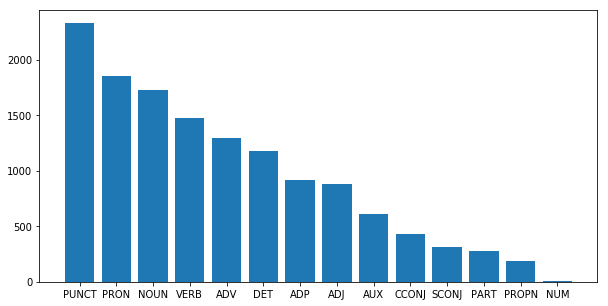

In [44]:
height = [count for _, count in sorted_pos_count]
bars = [tag for tag, _ in sorted_pos_count]

y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

## Aufgabe 4: Tagging mit NLTK

Auch NLTK enthält Modelle für Textannotationen. Testen Sie die in den NLTK-Kapiteln 3 und 5 beschriebenen Tagger (**POS, Segmentizer, Stemmer, Lemmatizer**) für das Englische aus (wie man einen POS-Tagger mit NLTK selbst trainiert, um etwa auch auf deutschen Texten POS-Tagging mit NLTK durchzuführen, ist Thema in einer späteren Sitzung).

- https://www.nltk.org/book/ch03.html
- https://www.nltk.org/book/ch05.html


> HINWEIS: NLTK ist nicht primär Annotationstool wie stanza/spacy, sondern eher für Preprocessing und trainieren eigener Modelle geeignet (nur wenige vortrainierte Sprachmodelle in NLTK enthalten).



In [45]:
import nltk

#### POS-Tagging:

In [46]:
# zb: pos-tagging
#from nltk.tokenize import word_tokenize
text = nltk.word_tokenize("And now for something completely different.")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ'),
 ('.', '.')]

In [47]:
#pos_tag basiert auf englischem Modell, kein sinnvolles Ergbenis z.B. für deutsche Texte):
text = nltk.word_tokenize(open('wahlverwandschaften.txt').read())
#text[0:10]
nltk.pos_tag(text[0:10])

[('Die', 'NNP'),
 ('Wahlverwandtschaften', 'NNP'),
 ('Ein', 'NNP'),
 ('Roman', 'NNP'),
 ('von', 'NNP'),
 ('Johann', 'NNP'),
 ('Wolfgang', 'NNP'),
 ('von', 'NNP'),
 ('Goethe', 'NNP'),
 ('Erster', 'NNP')]

In [48]:
#Case relevant für POS-Tagging!
text = nltk.word_tokenize(open('wahlverwandschaften.txt').read().lower())
#text[0:10]
nltk.pos_tag(text[0:10])

[('die', 'NN'),
 ('wahlverwandtschaften', 'WRB'),
 ('ein', 'JJ'),
 ('roman', 'NN'),
 ('von', 'NN'),
 ('johann', 'NN'),
 ('wolfgang', 'NN'),
 ('von', 'IN'),
 ('goethe', 'NN'),
 ('erster', 'NN')]

#### Sentence Segmentation:
- https://www.nltk.org/book/ch03.html


In [49]:
raw_text = " And now. Something completely different."

sents = nltk.sent_tokenize(raw_text)
print(sents)

[' And now.', 'Something completely different.']


#### NLTK-Stemming

In [50]:
from nltk.tokenize import word_tokenize

raw = """DENNIS: Listen, strange women lying in ponds distributing swords
is no basis for a system of government.  Supreme executive power derives from
a mandate from the masses, not from some farcical aquatic ceremony."""
tokens = word_tokenize(raw)

In [51]:
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
print([porter.stem(t) for t in tokens])

['denni', ':', 'listen', ',', 'strang', 'women', 'lie', 'in', 'pond', 'distribut', 'sword', 'is', 'no', 'basi', 'for', 'a', 'system', 'of', 'govern', '.', 'suprem', 'execut', 'power', 'deriv', 'from', 'a', 'mandat', 'from', 'the', 'mass', ',', 'not', 'from', 'some', 'farcic', 'aquat', 'ceremoni', '.']


In [52]:
print([lancaster.stem(t) for t in tokens])

['den', ':', 'list', ',', 'strange', 'wom', 'lying', 'in', 'pond', 'distribut', 'sword', 'is', 'no', 'bas', 'for', 'a', 'system', 'of', 'govern', '.', 'suprem', 'execut', 'pow', 'der', 'from', 'a', 'mand', 'from', 'the', 'mass', ',', 'not', 'from', 'som', 'farc', 'aqu', 'ceremony', '.']


#### NLTK-Lemmatizer

In [53]:
wnl = nltk.WordNetLemmatizer()
print([wnl.lemmatize(t) for t in tokens])

['DENNIS', ':', 'Listen', ',', 'strange', 'woman', 'lying', 'in', 'pond', 'distributing', 'sword', 'is', 'no', 'basis', 'for', 'a', 'system', 'of', 'government', '.', 'Supreme', 'executive', 'power', 'derives', 'from', 'a', 'mandate', 'from', 'the', 'mass', ',', 'not', 'from', 'some', 'farcical', 'aquatic', 'ceremony', '.']
